## Load libs

In [1]:
# Load Libraries
import os
import numpy as np
import pandas as pd
from surprise.model_selection import GridSearchCV
from surprise import *
from scipy import stats
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
from surprise.model_selection import RandomizedSearchCV
from datetime import datetime

from IESEGRecSys import eval
from IESEGRecSys.model import ContentBased

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

from IPython.core.display import HTML
from bing_image_urls import bing_image_urls
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import BayesianRidge

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\inderpreetsingh.rana\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inderpreetsingh.rana\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import dot, concatenate

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

### Load Data

In [5]:
# Set working dir
%cd "C:/Users/irana/OneDrive - IESEG/Documents/Courses/Semester_2/recsys/group_project"

# read data
artist_file = "data/Artists.dat"
tags_file = "data/tags.dat"
user_artist_file = "data/user_artists.dat"
user_tag_file = "data/user_taggedartists.dat"

In [6]:
# load data
artist = pd.read_table(artist_file)
tags = pd.read_table(tags_file, encoding='latin')
user_artist = pd.read_table(user_artist_file)
user_tag = pd.read_table(user_tag_file)

In [7]:
artist.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [8]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [9]:
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


### EDA & data cleaning

In [10]:
# check for na's
user_artist.isna().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [11]:
# look at the weights distribution
print("min:", min(user_artist.weight),"max: ", max(user_artist.weight))

min: 1 max:  352698


In [12]:
# Check for skewness of weights column
user_artist.skew()

userID       0.029016
artistID     1.746033
weight      43.269718
dtype: float64

<AxesSubplot:>

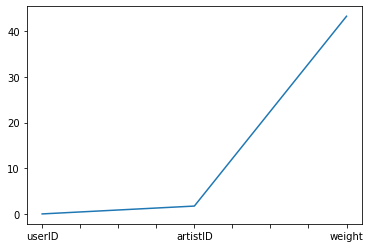

In [13]:
# Weights columns is highly skewed, visualization of the skewness
user_artist.skew().plot()

In [14]:
# Lets use Percentile Linearization to normalize the weight
# https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16

# **Check basic linerization
size = len(user_artist.weight)-1
user_artist["weights_scaled"] = user_artist.weight.rank(method='min').apply(lambda x: (x-1)/size)
user_artist["weights_scaled"].describe()

count    92834.000000
mean         0.499363
std          0.289144
min          0.000000
25%          0.248996
50%          0.499973
75%          0.749873
max          1.000000
Name: weights_scaled, dtype: float64

In [15]:
# We now scale our data between 1-5 as user ratings

# initiate scaller
scaler = MinMaxScaler(feature_range=(1, 5))
#scale weights
user_artist["weights_scaled"] =  scaler.fit_transform(user_artist[["weights_scaled"]])

# remove unwanted cols
user_artist_cleaned = user_artist[["userID", "artistID", "weights_scaled"]]
user_artist_cleaned.columns = ("user","item","rating")

#check rating scales
print("min:", min(user_artist_cleaned.rating),"max: ", max(user_artist_cleaned.rating))

min: 1.0 max:  5.0


In [16]:
# Round the rating to fix the bias towards highest ratings (which is quite low in number), and turn all ratings to integers
import shutup
shutup.please()
user_artist_cleaned["rating"] = user_artist_cleaned["rating"].apply(lambda x: round(x))
shutup.unmute_warnings()

In [17]:
user_artist_cleaned.skew()

user      0.029016
item      1.746033
rating    0.002611
dtype: float64

In [18]:
user_artist_cleaned.head()

,user,item,rating
0,2,51,5
1,2,52,5
2,2,53,5
3,2,54,5
4,2,55,5


In [19]:
pd.DataFrame(user_artist_cleaned.groupby("rating")["user"]
            .agg('count')).sort_values("rating", ascending=False)

,user
rating,
5,11601
4,23145
3,23141
2,23242
1,11705



#### Data cleaning for content based

In [20]:
# Merge data fields into one data columns
if len(user_tag.day)==1:
    user_tag["day"] = '0' + user_tag["day"].astype('str')
    user_tag["month"] = '0' + user_tag["day"].astype('str')

df = user_tag.merge(tags, how="left")
df['tag_date'] = df['day'].map(str) + '-' + df['month'].map(str) + '-' + df['year'].map(str)
print("min: ", min(df.tag_date), "| max: ",max(df.tag_date))

cols_to_drop = ["tagID", "day","month","year"]
df.drop(cols_to_drop, axis=1, inplace=True)
print(df.tagValue.nunique())

min:  1-1-2006 | max:  9-5-2011
9749


In [21]:
df_backup = df

#### Create TF-IDF/Document term matrix for content based

In [22]:
pd.options.mode.chained_assignment = None
tag_art = df[["artistID","tagValue"]]
tag_art["tag_conc"] = tag_art[['artistID','tagValue']].groupby(['artistID'])['tagValue'].transform(lambda x: ', '.join(x))
tag_art.drop("tagValue",axis=1, inplace=True)

tag_art = tag_art.drop_duplicates().reset_index(drop=True)

print("unique tag values: ", df.tagValue.nunique())

# Tokenize, case conversion & only alphabetic
tokens = tag_art['tag_conc'].apply(lambda txt: [word.lower() for word in word_tokenize(str(txt)) if word.isalpha()])
# setup stop words list
stop_words = stopwords.words('english')

stemmer = SnowballStemmer("english")

# remove stopwords, stem
token_stem = tokens.apply(lambda lst_token: [stemmer.stem(tok) for tok in lst_token if tok not in stop_words and len(tok) > 2])


# TFIDF vectorizer
tfidf = TfidfVectorizer(min_df=5)

# apply tf-idf vectorizer -> document-term-matrix in sparse format
dtm = tfidf.fit_transform([" ".join(x) for x in token_stem])

print("dtm shape: ", dtm.shape)

df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names(), index=tag_art.index)
df_dtm.head()

unique tag values:  9749
dtm shape:  (12523, 1773)


,aaliyah,aana,absolut,abstract,abyss,acid,acoust,actress,actual,adam,...,yet,york,yorkshir,young,your,zadrotstvo,zealand,zombi,zone,ztt
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.129041,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.393458,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093822,0.0


In [23]:
# group by artist to create a matrix based on tag value
df = df_backup
df = df.groupby(['artistID','tagValue'])['tagValue'].count().unstack().fillna(0)

In [24]:
df.head()

tagValue,'80s,-pearl fashion music,0 play yet,00,00's,007,00s,00s rock,1,1008,...,zikirli,zmiel pierogi,zmierzch,zombie,zombie rave,zombieland,zoocore,zornish,ztt,zu
artistID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Merge data fields into one data columns
if len(user_tag.day)==1:
    user_tag["day"] = '0' + user_tag["day"].astype('str')
    user_tag["month"] = '0' + user_tag["day"].astype('str')

df_time = user_tag.merge(tags, how="left")
df_time['tag_date'] = df_time['day'].map(str) + '-' + df_time['month'].map(str) + '-' + df_time['year'].map(str)
print("min: ", min(df_time.tag_date), "| max: ",max(df_time.tag_date))

cols_to_drop = ["tagID", "day","month","year"]
df_time.drop(cols_to_drop, axis=1, inplace=True)
print(df_time.tagValue.nunique())

df_time.head()

min:  1-1-2006 | max:  9-5-2011
9749


,userID,artistID,tagValue,tag_date
0,2,52,chillout,1-4-2009
1,2,52,downtempo,1-4-2009
2,2,52,electronic,1-4-2009
3,2,52,trip-hop,1-4-2009
4,2,52,female vovalists,1-4-2009


##### Data prep for content based using how old the tags are

In [26]:
df_time_t = df_time
df_time.sort_values(['userID', 'artistID']).groupby(['artistID'], sort=False).tagValue.apply(' '.join).reset_index(name='tag_c')

,artistID,tag_c
0,52,chillout downtempo electronic trip-hop female ...
1,63,chillout ambient new age gregorian chant chill...
2,73,chillout ambient downtempo electronic lounge t...
3,94,chillout downtempo lounge trip-hop acid jazz c...
4,96,80's pop guilty pleasures chill zone miserable...
...,...,...
12518,18719,instrumental hip-hop
12519,18721,downtempo instrumental hip-hop
12520,18723,drum and bass liquid funk
12521,3855,melancholic rock


In [27]:
from datetime import datetime

In [28]:
df_time['tag_date'] = df_time['tag_date'].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y') if str(x) != 'nan' else np.nan)
#df_time['tag_date'].hist(bins=200)

df_time['VeryVeryOld'] = df_time['tag_date'].apply(lambda x: 1 if x.year < 2005 else 0)
df_time['VeryOld']     = df_time['tag_date'].apply(lambda x: 1 if (x.year >= 2006) and (x.year < 2006) else 0)
df_time['Old']         = df_time['tag_date'].apply(lambda x: 1 if (x.year >= 2007) and (x.year < 2008) else 0)
df_time['Recent']      = df_time['tag_date'].apply(lambda x: 1 if (x.year >= 2009) else 0)
df_time['New']         = df_time['tag_date'].apply(lambda x: 1 if x.year >= 2010 else 0)
df_time.head()

,userID,artistID,tagValue,tag_date,VeryVeryOld,VeryOld,Old,Recent,New
0,2,52,chillout,2009-04-01,0,0,0,1,0
1,2,52,downtempo,2009-04-01,0,0,0,1,0
2,2,52,electronic,2009-04-01,0,0,0,1,0
3,2,52,trip-hop,2009-04-01,0,0,0,1,0
4,2,52,female vovalists,2009-04-01,0,0,0,1,0


In [30]:
plot = df_time[["tag_date","VeryVeryOld","VeryOld","Old","Recent","New"]]

<AxesSubplot:xlabel='tag_date'>

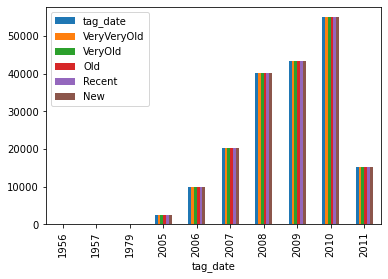

In [31]:
plot.groupby([df_time["tag_date"].dt.year]).count().plot(kind="bar")

In [32]:
df_time.drop(["userID","tag_date"], axis=1, inplace=True)
df_time.columns

Index(['artistID', 'tagValue', 'VeryVeryOld', 'VeryOld', 'Old', 'Recent',
       'New'],
      dtype='object')

In [33]:
df_time_backup = df_time
df_time = df_time.drop(["tagValue"], axis=1)
df_time = df_time.drop_duplicates()
df_time.head()

,artistID,VeryVeryOld,VeryOld,Old,Recent,New
0,52,0,0,0,1,0
5,63,0,0,0,1,0
9,73,0,0,0,1,0
17,94,0,0,0,1,0
25,96,0,0,0,1,0


In [34]:
#df_time_backup.head()

In [35]:
# # create a matrix for tag values
df_time_tag_art = pd.get_dummies(df_time_backup, columns=["tagValue"])

# # impute mean for the tag values
df_time_tag_art = df_time_tag_art.groupby("artistID").mean()
df_time_tag_art.head()

,VeryVeryOld,VeryOld,Old,Recent,New,tagValue_'80s,tagValue_-pearl fashion music,tagValue_0 play yet,tagValue_00,tagValue_00's,...,tagValue_zikirli,tagValue_zmiel pierogi,tagValue_zmierzch,tagValue_zombie,tagValue_zombie rave,tagValue_zombieland,tagValue_zoocore,tagValue_zornish,tagValue_ztt,tagValue_zu
artistID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.000000,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.148148,0.555556,0.259259,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.222222,0.111111,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.136364,0.181818,0.181818,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.428571,0.571429,0.428571,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Recomendations

### We first try some basic colaborative filtering techniques

In [36]:
cf_data = user_artist_cleaned
cf_data.head()

,user,item,rating
0,2,51,5
1,2,52,5
2,2,53,5
3,2,54,5
4,2,55,5


In [37]:
data = cf_data

# Create train test split
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data.rating)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(data.shape)
print(train.shape)
print(test.shape)

(92834, 3)
(74267, 3)
(18567, 3)


In [38]:
# create train/test split for surprise dataset
reader = Reader(rating_scale=(1, 5))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

#### Run all colaborative filtering algos with default parametres to get a benchmark using cross validation

In [39]:
benchmark = []
# Iterate over all algorithms
# RMSE, MAE, NDCG and F1-Score

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

for algorithm in algorithms:
    print("Starting: " ,algorithm)
    # Perform cross validation
    results = cross_validate(algorithm, Dataset.load_from_df(data, reader), measures=['RMSE','MAE','fcp'], cv=3, verbose=False)    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,algorithm, "\n")

print ('\n\tDONE\n')

Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002285BF83EB0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002285BF83EB0> 

Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000002285BF83D90>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000002285BF83D90> 

Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000002285BF83E80>
Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000002285BF83E80> 

Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000002285BF83DC0>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000002285BF83DC0> 

Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000002285BF83D60>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000002285BF83D60> 

Starting:  <surprise.prediction_

In [40]:
## * add other metrics
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,test_fcp,fit_time,test_time
Algorithm,,,,,
SVDpp,0.730838,0.567270,0.582684,34.407464,1.438019
SVD,0.745561,0.587228,0.568805,4.078057,0.233585
BaselineOnly,0.793179,0.651339,0.582861,0.281005,0.153696
KNNBaseline,0.810369,0.651382,0.574213,0.726185,3.045696
KNNWithMeans,0.864114,0.662981,0.558312,0.512588,2.695360
KNNWithZScore,0.866575,0.661138,0.558769,0.614671,2.914766
SlopeOne,0.885017,0.675416,0.557944,9.216442,1.079679
NMF,0.916929,0.700507,0.552979,6.171070,0.312670
CoClustering,0.917408,0.709410,0.551378,3.418425,0.162667


##### Run top 5 algos based on RMSE to get the remaining eval metrics

In [41]:
benchmark = pd.DataFrame(index=["RMSE", "MAE", "Recall", "Precision","F1","NDCG@5"])
pred = []

# Iterate over top 5 algorithms
algorithms = [SVD(), SVDpp(), KNNBaseline(), KNNWithMeans(), BaselineOnly()]
n = 1

for algorithm in algorithms:
    algorithm.fit(df_train)

    pred =  algorithm.test(df_test)
    tmp= pd.DataFrame(eval.evaluate(pred, topn=5, rating_cutoff=4).rename(columns={'value':n}))
    benchmark = benchmark.merge(tmp, left_index=True, right_index=True)
    n = n+1
    
benchmark.columns = ["SVD","SVDpp","KNNBaseline","KNNWithMeans","BaselineOnly"]
print ('\n\tDONE\n')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

	DONE



In [42]:
benchmark

,SVD,SVDpp,KNNBaseline,KNNWithMeans,BaselineOnly
RMSE,0.741980,0.729459,0.796914,0.855696,0.780664
MAE,0.579896,0.563871,0.637394,0.655458,0.637436
Recall,0.390992,0.425817,0.340049,0.410563,0.224781
Precision,0.941768,0.939962,0.915537,0.903992,0.971998
F1,0.552573,0.586115,0.495908,0.564671,0.365124
NDCG@5,0.851972,0.853657,0.851091,0.849124,0.851209


## Hyperparameter tuning

#### Gridsearch on SVD ++

In [43]:
### We ran a few grid searches, if we had more powerful machines, we could still run higher grid searches and tune the hypermarametres even more

def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse','mse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

params= {
    "n_epochs": [100, 150],
    "lr_all": [0.002, 0.003],
    "reg_all": [0.2, 0.3, 0.04],
    "n_factors" : [50, 500]
}

In [44]:
gs = GridSearchCV(SVDpp(), params, measures=['rmse', 'mae'], cv=3)

In [ ]:
gs.fit(Dataset.load_from_df(train, reader))

In [ ]:
print(gs.best_score['rmse'])

In [ ]:
gs.best_params

In [45]:
# run with tuned parametres
reader = Reader(rating_scale=(1, 5))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

svd_pp = SVDpp(n_factors=170, n_epochs=240, lr_all=0.017, reg_all=0.1)
startTraining = datetime.now()

svd_pp.fit(df_train)

endTraining = datetime.now()
print("> OK \t\t It Took: ", (endTraining-startTraining).seconds, "seconds")

> OK 		 It Took:  2918 seconds


In [52]:
pred = svd_pp.test(df_test)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

svdpp_tuned_res =  pd.DataFrame(eval.evaluate(pred, topn=5, rating_cutoff=4).rename(columns={'value':"svd_pp_Tuned"}))
svdpp_tuned_res

Impossible: 0.0000


,svd_pp_Tuned
RMSE,0.775988
MAE,0.622177
Recall,0.333861
Precision,0.944625
F1,0.493355
NDCG@5,0.848835


### Colaborative filtering using tensorflow

In [47]:
dataset = cf_data
dataset.columns = ['user_id', 'item_id', 'ratings']
len(dataset["user_id"].unique()), len(dataset["item_id"].unique())

(1892, 17632)

In [48]:
# Get unique user item pair
uniq_items = pd.DataFrame(dataset["item_id"].unique())

#uniq_items['user_map_key'] = uniq_items.index + 42
uniq_items.columns = ["item_id"]

#merging the data back
dataset = pd.merge(dataset, uniq_items, on="item_id")

len(dataset.user_id.unique()), len(dataset.item_id.unique())

#dataset.drop("item_id", axis=1, inplace=True)

(1892, 17632)

In [49]:
# change ratings to category
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [50]:
# Drop the user item key
#dataset.drop("user_map_key", axis=1, inplace=True)

#create train test split
train, test = train_test_split(dataset, test_size=0.2)

In [53]:
# use length of user and item to create network layers
n_users, n_artists = len(dataset.user_id.unique()), len(dataset.item_id.unique())
# using default parameter value for latent factors
n_latent_factors = 3

In [54]:
## Build model
n_latent_factors_user = 5
n_latent_factors_artist = 8

# Use data shape as out imput layer for artist
artist_input = keras.layers.Input(shape=[1],name='Item')
artist_embedding = keras.layers.Embedding(n_artists + 1, n_latent_factors_artist, name='Artist-Embedding')(artist_input)

## Flatten  the data and create artist vector
artist_vec = keras.layers.Flatten(name='FlattenArtisi')(artist_embedding)
artist_vec = keras.layers.Dropout(0.2)(artist_vec)

# we use data shape as out imput layer for user
user_input = keras.layers.Input(shape=[1],name='User')

## Flatten  the data and create user vector
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)

# Merge user and artist vectors
concat = concatenate([artist_vec, user_vec], axis=1, name='Concat')

### tuning the layers
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
# add optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.051)
# build the model
model = keras.Model([user_input, artist_input], result)
# compile the model
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Artist-Embedding (Embedding)   (None, 1, 8)         141064      ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         9465        ['User[0][0]']                   
                                                                                              

In [466]:
history = model.fit([train.user_id, train.item_id], train.ratings, epochs=20)

Epoch 1/20
2321/2321 [==============================] - ETA: 1:04:59 - loss: 3.26 - ETA: 6s - loss: 1.7393     - ETA: 7s - loss: 1.471 - ETA: 7s - loss: 1.398 - ETA: 7s - loss: 1.388 - ETA: 7s - loss: 1.351 - ETA: 6s - loss: 1.304 - ETA: 6s - loss: 1.271 - ETA: 6s - loss: 1.241 - ETA: 6s - loss: 1.223 - ETA: 6s - loss: 1.207 - ETA: 7s - loss: 1.203 - ETA: 8s - loss: 1.203 - ETA: 8s - loss: 1.202 - ETA: 8s - loss: 1.187 - ETA: 8s - loss: 1.180 - ETA: 8s - loss: 1.170 - ETA: 7s - loss: 1.157 - ETA: 7s - loss: 1.145 - ETA: 7s - loss: 1.135 - ETA: 7s - loss: 1.144 - ETA: 7s - loss: 1.157 - ETA: 7s - loss: 1.163 - ETA: 7s - loss: 1.161 - ETA: 7s - loss: 1.158 - ETA: 7s - loss: 1.151 - ETA: 7s - loss: 1.149 - ETA: 7s - loss: 1.147 - ETA: 7s - loss: 1.146 - ETA: 6s - loss: 1.143 - ETA: 6s - loss: 1.138 - ETA: 6s - loss: 1.135 - ETA: 6s - loss: 1.135 - ETA: 6s - loss: 1.133 - ETA: 6s - loss: 1.132 - ETA: 6s - loss: 1.129 - ETA: 6s - loss: 1.125 - ETA: 6s - loss: 1.124 - ETA: 6s - loss: 1.126 -

In [ ]:
# RMSE is too low so we don't continue with this model
# We did however saw improvements when we increase the number of epochs, but having longer epochs crashed our system.
# Also with 500 epochs and lower learning rate that we tried, the RMSE does improve, but it still is lower then SVD ++ and other CF algo's
# that we ran.
# In future we can explore content based recomendations with tensorflow which theoritically will improve the recomendations.

math.sqrt(mean_absolute_error(test.ratings, model.predict([test.user_id, test.item_id])))

In [ ]:
#nn_predictions =  model.predict([test.user_id, test.item_id])

## Content based recomendations

### Using TF-IDF

In [55]:
train_copy = train.reset_index(drop=True)
train_copy.columns = ["user", "item", "rating"]

train_sub = train_copy[train_copy.item.isin(df_dtm.index)].drop_duplicates().reset_index(drop=True)
df_cont_sub = df_dtm[df_dtm.index.isin(train_sub.item)]

df_train = Dataset.load_from_df(train_sub, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

In [56]:
# content-based
cb = ContentBased(NN=10)
cb.fit(df_dtm)
cb.fit_ratings(df_train)
cb_pred = cb.test(df_test)

# item-based
options = {'name':'cosine', 'user_based':False}
ib = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)
ib.fit(df_train)
ib_pred = ib.test(df_test)

# svd
mf = SVD(n_factors=20, biased=False, random_state=42)
mf.fit(df_train)
mf_pred = mf.test(df_test)

models = {"CB_10":cb_pred, "IB_15":ib_pred, "SVD_20":mf_pred}
overview = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=4) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

c:\Users\inderpreetsingh.rana\Downloads\group_project\group_project\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


Computing the cosine similarity matrix...
Done computing similarity matrix.


,CB_10,IB_15,SVD_20
RMSE,0.826673,0.925603,1.112123
MAE,0.632309,0.714531,0.826212
Recall,0.406304,0.381375,0.271060
Precision,0.931057,0.904212,0.911807
F1,0.565729,0.536477,0.417891
NDCG@5,0.886392,0.836572,0.847435


In [57]:
train_copy = train.reset_index(drop=True)
train_copy.columns = ["user", "item", "rating"]

#Subset data so we have same items in both content and rating tables

unique_artist_cont = pd.DataFrame(df[df.index.isin(train_copy.item)].index)
unique_artist_cont = unique_artist_cont.artistID.unique()

unique_artist_cont = pd.DataFrame(df[df.index.isin(train_copy.item)].index).values.ravel()

train_cb_ratings = train_copy[train_copy.item.isin(unique_artist_cont)].reset_index(drop=True)

train_cb_content = df[df.index.isin(unique_artist_cont)]

In [58]:
# init content-based
cb_one = ContentBased(NN=20)

# fit on content
cb_one.fit(train_cb_content)

# fit on train_ratings (The 4509 artist that are missing are the ones with 0 tags)
cb_one.fit_ratings(Dataset.load_from_df(train_cb_ratings, reader).build_full_trainset())

# predict test ratings
cb_one_pred = cb_one.test(df_test)

# compute metrics
cb_res = eval.evaluate(cb_one_pred, topn=5, rating_cutoff=4).rename(columns={'value':'Content_based_20'})
cb_res

c:\Users\inderpreetsingh.rana\Downloads\group_project\group_project\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


,Content_based_20
RMSE,0.915749
MAE,0.705154
Recall,0.347421
Precision,0.931617
F1,0.506105
NDCG@5,0.867048


In [59]:
#Validate our results
pd.DataFrame(cb_one_pred)

,uid,iid,r_ui,est,details
0,235,683,4,3.861111,{'was_impossible': False}
1,207,3869,5,2.981389,"{'was_impossible': True, 'reason': 'User or it..."
2,1625,15875,1,2.981389,"{'was_impossible': True, 'reason': 'User or it..."
3,1696,3201,3,3.583333,{'was_impossible': False}
4,570,2364,4,4.297297,{'was_impossible': False}
...,...,...,...,...,...
18562,1410,1650,2,2.774194,{'was_impossible': False}
18563,546,8122,4,2.981389,"{'was_impossible': True, 'reason': 'User or it..."
18564,1121,6036,1,2.981389,"{'was_impossible': True, 'reason': 'User or it..."
18565,47,1507,3,3.526316,{'was_impossible': False}


#### Content based (based on how old the tags are)

In [60]:
#Subset the data so artist in content and user/artist dataset match
train_copy = train.reset_index(drop=True)
train_copy.columns = ["user", "item", "rating"]
df_time_train = df_time[df_time.artistID.isin(train_copy.item.values)].reset_index(drop=True)

# init content-based
cb_time = ContentBased(NN=10)

# fit on content
cb_time.fit(df_time_train)

# fit on train_ratings
cb_time.fit_ratings(df_train)

# predict test ratings
cb_time_pred = cb_time.test(df_test)

# compute metrics
cb_time_res = eval.evaluate(cb_time_pred, topn=5, rating_cutoff=4).rename(columns={'value':'Content_based_Time_10'})
cb_time_res

c:\Users\inderpreetsingh.rana\Downloads\group_project\group_project\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


,Content_based_Time_10
RMSE,0.751959
MAE,0.577453
Recall,0.447708
Precision,0.929506
F1,0.604332
NDCG@5,0.881599


### Content based using all available metrics (Tags and Time)

In [61]:
# check if both tables have same artists
print(
    len(train_copy[train_copy.item.isin(df_time_tag_art.index)].drop_duplicates().reset_index(drop=True)),
    "-----",
    len(df_time_tag_art[df_time_tag_art.index.isin(train_copy.item.values)])
)

61946 ----- 10509


In [62]:
#Subset the data so artist in content and user/item dataset match

df_time_tag_train = train_copy[train_copy.item.isin(df_time_tag_art.index)].drop_duplicates().reset_index(drop=True)
df_cont_sub = df[df.index.isin(df_time_tag_train.item)]

cb_all = ContentBased(NN=25)

# fit on content
cb_all.fit(df_cont_sub)

# fit on train_ratings (The 4509 artist that are missing are the ones with 0 tags)
cb_all.fit_ratings(Dataset.load_from_df(df_time_tag_train, reader).build_full_trainset())

# predict test ratings
cb_pred_all = cb_all.test(df_test)

# compute metrics
cb_all_res = eval.evaluate(cb_pred_all, topn=5, rating_cutoff=4).rename(columns={'value':'Content_based_All_25'})
cb_all_res

c:\Users\inderpreetsingh.rana\Downloads\group_project\group_project\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


,Content_based_All_25
RMSE,0.915259
MAE,0.704764
Recall,0.347708
Precision,0.931312
F1,0.506363
NDCG@5,0.865141


# Hybrid Recomendation Systems

#### Hybrid 1: Using content and item based

In [63]:
# Hybrid based on outputs

# extract predictions content-based and item-based
df_pred_cb, df_pred_ib = pd.DataFrame(cb_time_pred), pd.DataFrame(ib_pred)

df_hybrid = df_pred_cb.copy()

# Combine predictions using mean
df_hybrid['est'] = (np.array(df_pred_cb['est']) + np.array(df_pred_ib['est'])) / 2

hybrid_one = eval.evaluate(df_hybrid, topn=5, rating_cutoff=4).rename(columns={'value':'Hybrid_One'})

df_hybrid.head()

,uid,iid,r_ui,est,details
0,235,683,4,3.946021,{'was_impossible': False}
1,207,3869,5,4.733904,{'was_impossible': False}
2,1625,15875,1,2.240054,{'was_impossible': False}
3,1696,3201,3,3.553951,{'was_impossible': False}
4,570,2364,4,4.249648,{'was_impossible': False}


#### Hybrid Two: Using Linear Regression

In [64]:
# training set for Linear Regression model
lr_train = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_train['cb_pred'] = df_pred_cb['est']
lr_train.head()

,target,ib_pred,cb_pred
0,4,3.935944,3.956098
1,5,4.862544,4.605263
2,1,3.021649,1.458459
3,3,3.532902,3.575000
4,4,4.199297,4.300000


In [65]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression

X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model = LinearRegression().fit(X,y)

In [66]:
# make prediction

# Content Based
cb_pred2 = cb.test(list(test.itertuples(index=False, name=None)))

# Item Based
ib_pred2 = ib.test(list(test.itertuples(index=False, name=None)))

# convert to df
df_pred_cb2, df_pred_ib2 = pd.DataFrame(cb_pred2), pd.DataFrame(ib_pred2)

##### Hybrid - Mean
df_hybrid2 = df_pred_ib2.copy()
df_hybrid2['est'] = (np.array(df_pred_cb2['est']) + np.array(df_pred_ib2['est'])) / 2

In [67]:
##### Hybrid - Linear Regression model
# get test set
lr_test = df_pred_ib2[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_test['cb_pred'] = df_pred_cb2['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model.predict(X_test)

# transform in surprise format
df_lr = df_pred_ib2.copy()
df_lr['est'] = lr_pred

In [68]:
hybrid_LR = eval.evaluate(df_lr, topn=5, rating_cutoff=4).rename(columns={'value':'Hybrid_LR'})

#### Hybrid 3: Using Random Forest

In [69]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.head()

# create target and predictors split
X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=15, n_estimators=120).fit(X,y)

# predict
rf_pred = rf_model.predict(X_test)

# transform in surprise format
df_rf = df_pred_ib2.copy()
df_rf['est'] = rf_pred

hybrid_RF = eval.evaluate(df_rf, topn=5, rating_cutoff=4).rename(columns={'value':'Hybrid_RF'})

### Hybrid Four: Using AdaBoost

In [70]:
# copy lr train set
ada_train = lr_train.copy()
ada_train.head()


# create target and predictors split
X, y = ada_train.loc[:,ada_train.columns != 'target'], np.array(ada_train['target'])

## initiate model with tuned parametres
boost_model = AdaBoostRegressor(base_estimator=RandomForestRegressor(),
 n_estimators=500, random_state=42)

# fit Adaboost forest model
boost_model = boost_model.fit(X,y)

# predict
boost_pred = boost_model.predict(X_test)

# transform in surprise format
df_boost = df_pred_ib2.copy()
df_boost['est'] = boost_pred

hybrid_Ada = eval.evaluate(df_boost, topn=5, rating_cutoff=4).rename(columns={'value':'Hybrid_AdaBoost'})

#### Hybrid 5: Using BayesianRidge

In [71]:
# copy lr train set
GaussianNB_train = lr_train.copy()

X, y = ada_train.loc[:,ada_train.columns != 'target'], np.array(ada_train['target'])

GaussianNB = BayesianRidge(alpha_init=0.0012, normalize=True)

# fit Adaboost forest model
GaussianNB = GaussianNB.fit(X,y)

# predict
GaussianNB_pred = GaussianNB.predict(X_test)

# transform in surprise format
df_GaussianNB = df_pred_ib2.copy()
df_GaussianNB['est'] = GaussianNB_pred

# Evaluate
hybrid_GaussianNB = eval.evaluate(df_GaussianNB, topn=4, rating_cutoff=5).rename(columns={'value':'Hybrid_GaussianNB'})

c:\Users\inderpreetsingh.rana\Downloads\group_project\group_project\IESEGRecSys\eval.py:147: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP+FP)


In [73]:
## Function shared in Rec sys class IESEG MDB 2021-2022
def predict_user_topn(model, train, user, topk=15, item_col='item'):
    """
    Returns topk items for specified user.
    Return type: list
    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids
    """
    # intermediate result dict
    res = {item_col:[], 'pred':[], 'detail':[]} 
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

#### Do some Manual validation

In [74]:
#manual validation
#user_tag.merge(tags)[user_tag.merge(tags).userID==613]

In [75]:
#pd.set_option('display.max_colwidth', 30)
#tag_art[tag_art["artistID"]==707].tag_conc

In [76]:
#predict_user_topn(svd_pp, test, 51, topk=10, item_col='item')

### Model Evaluation

In [78]:
eval_grid = benchmark.merge(cb_res.merge(cb_time_res, left_index=True, right_index=True) ,left_index=True, right_index=True)
eval_grid = eval_grid.merge(cb_all_res, left_index=True, right_index=True) 
eval_grid = eval_grid.merge(hybrid_Ada, left_index=True, right_index=True) 
eval_grid = eval_grid.merge(hybrid_LR, left_index=True, right_index=True) 
eval_grid = eval_grid.merge(hybrid_RF, left_index=True, right_index=True) 
eval_grid = eval_grid.merge(hybrid_GaussianNB, left_index=True, right_index=True) 
eval_grid = eval_grid.merge(svdpp_tuned_res, left_index=True, right_index=True) 
eval_grid

,SVD,SVDpp,KNNBaseline,KNNWithMeans,BaselineOnly,Content_based_20,Content_based_Time_10,Content_based_All_25,Hybrid_AdaBoost,Hybrid_LR,Hybrid_RF,Hybrid_GaussianNB,svd_pp_Tuned
RMSE,0.741980,0.729459,0.796914,0.855696,0.780664,0.915749,0.751959,0.915259,0.721202,0.826944,0.720687,0.826935,0.775988
MAE,0.579896,0.563871,0.637394,0.655458,0.637436,0.705154,0.577453,0.704764,0.515980,0.634450,0.536618,0.634454,0.622177
Recall,0.390992,0.425817,0.340049,0.410563,0.224781,0.347421,0.447708,0.347708,0.498997,0.386676,0.413897,0.000000,0.333861
Precision,0.941768,0.939962,0.915537,0.903992,0.971998,0.931617,0.929506,0.931312,0.980298,0.939436,0.984663,NaN,0.944625
F1,0.552573,0.586115,0.495908,0.564671,0.365124,0.506105,0.604332,0.506363,0.661350,0.547853,0.582812,NaN,0.493355


In [79]:
eval_grid.transpose().sort_values(by="RMSE")

,RMSE,MAE,Recall,Precision,F1
Hybrid_RF,0.720687,0.536618,0.413897,0.984663,0.582812
Hybrid_AdaBoost,0.721202,0.515980,0.498997,0.980298,0.661350
SVDpp,0.729459,0.563871,0.425817,0.939962,0.586115
SVD,0.741980,0.579896,0.390992,0.941768,0.552573
Content_based_Time_10,0.751959,0.577453,0.447708,0.929506,0.604332
svd_pp_Tuned,0.775988,0.622177,0.333861,0.944625,0.493355
BaselineOnly,0.780664,0.637436,0.224781,0.971998,0.365124
KNNBaseline,0.796914,0.637394,0.340049,0.915537,0.495908
Hybrid_GaussianNB,0.826935,0.634454,0.000000,NaN,NaN
Hybrid_LR,0.826944,0.634450,0.386676,0.939436,0.547853


### Best Model

In [81]:
print("Best model & parametres based on all evaluation metrics: " ,boost_model)

Best model & parametres based on all evaluation metrics:  AdaBoostRegressor(base_estimator=RandomForestRegressor(), n_estimators=500,
                  random_state=42)


In [82]:
## Create a artist DF to show the users their recomended artists
artist_info = artist.merge(user_artist, left_on="id", right_on="artistID")[['artistID',
 'name', 'url', 'pictureURL']].drop_duplicates().sort_values(by="name").reset_index(drop=True)

artist_info.tail(5)

,artistID,name,url,pictureURL
17627,17680,ＲＥＤ,http://www.last.fm/music/%EF%BC%B2%EF%BC%A5%EF...,http://userserve-ak.last.fm/serve/252/223965.jpg
17628,17655,ＶａｎｅｓｓＡ,http://www.last.fm/music/%EF%BC%B6%EF%BD%81%EF...,http://userserve-ak.last.fm/serve/252/46409651...
17629,17678,ｂｏｏｇｉｅｍａｎ,http://www.last.fm/music/+noredirect/%EF%BD%82...,http://userserve-ak.last.fm/serve/252/45131149...
17630,17654,ｂｏｒｎ,http://www.last.fm/music/+noredirect/%EF%BD%82...,http://userserve-ak.last.fm/serve/252/47234673...
17631,17659,ｍａｃｈｉｎｅ,http://www.last.fm/music/%EF%BD%8D%EF%BD%81%EF...,http://userserve-ak.last.fm/serve/252/24420397...


#### Recomendations for top model

In [127]:
art_tag_info = df_time_t.sort_values(['userID', 'artistID']).groupby(['artistID'], sort=False).tagValue.apply(' ,'.join).reset_index(name='artist_tag')

In [135]:
artist_info_tags = artist_info.merge(art_tag_info, left_on="artistID", right_on="artistID", how="left", sort=True).reset_index(drop=True)
artist_info_tags.head()

,artistID,name,url,pictureURL,artist_tag
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,"weeabo ,jrock ,j-rock ,visual kei ,better than..."
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,"german ,seen live ,darkwave ,industrial ,germa..."
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,"black metal ,black metal ,norwegian black meta..."
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,"j-rock ,visual kei ,metal ,gothic japanese ,ba..."
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,"gothic ,gothic rock ,darkwave ,darkwave ,death..."


In [138]:
# Function to display recomendations using SVD ++ model

def recomend(user, top_n=5):
        my_recs = []
        for iid in artist_info.artistID:
            my_recs.append((iid, svd_pp.predict(uid=user,iid=iid).est))
        recs_df = pd.DataFrame(my_recs, columns=['iid', 'predictions']).sort_values('predictions',
                    ascending=False).head(top_n)
        return recs_df

def show_reccomendations_svd(user_id, n_recs=5):
    
    final_recs = recomend(user_id).merge(artist_info_tags, left_on="iid", right_on="artistID", how="inner")[[
    "name","url", "pictureURL", "artist_tag"]]

    art_pic = []
    for n in final_recs["name"]:
        url = bing_image_urls(n, limit=1)
        pic = {'name': n, 'image_url': url}
        art_pic.append(pic)

    art_pic = pd.DataFrame(art_pic)
    art_pic["image_url"] = art_pic["image_url"].apply(pd.Series)    

    final_recs = final_recs.merge(art_pic, left_on="name", right_on="name", how="inner")[["image_url","name","url", "artist_tag"]]
    # Rendering the dataframe as HTML table
    final_recs_display = HTML(final_recs.to_html(render_links=True,escape=False, formatters=dict(image_url=path_to_image_html)))

    return final_recs_display

#### Recomendations for Hybrid model

In [139]:
# function to onverting links to html tags
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'


boost_pred = boost_model.predict(X_test)

# transform in surprise format
df_boost = df_pred_ib2.copy()
df_boost['est'] = boost_pred


# Function to display recomendations using hybrid model
def show_reccomendations_hybrid(user_id, n_recs=5):
    ada_top_recs = df_boost[df_boost["uid"]==user_id][["uid","iid"]].head(n_recs)

    final_recs = ada_top_recs.merge(artist_info_tags, left_on="iid", right_on="artistID", how="inner")[[
    "name","url", "pictureURL", "artist_tag"]]
    
    art_pic = []
    for n in final_recs["name"]:
        url = bing_image_urls(n, limit=1)
        pic = {'name': n, 'image_url': url}
        art_pic.append(pic)

    art_pic = pd.DataFrame(art_pic)
    art_pic["image_url"] = art_pic["image_url"].apply(pd.Series)    

    final_recs = final_recs.merge(art_pic, left_on="name", right_on="name", how="inner")[["image_url","name","url", "artist_tag"]]
    # Rendering the dataframe as HTML table
    final_recs_display = HTML(final_recs.to_html(render_links=True,escape=False, formatters=dict(image_url=path_to_image_html)))

    return final_recs_display

#### Diversified recomendations

In [148]:
# Function to display diversified recomendations
def show_reccomendations_div(user_id, n_recs=5):
    n_recs = n_recs-1
    ada_top_recs = df_boost[df_boost["uid"]==user_id][["uid","iid"]].head(n_recs)

    final_recs = ada_top_recs.merge(artist_info_tags, left_on="iid", right_on="artistID", how="inner")[[
    "name","url", "pictureURL", "artist_tag"]]

    final_recs_b = recomend(user_id).merge(artist_info_tags, left_on="iid", right_on="artistID", how="inner")[[
    "name","url", "pictureURL", "artist_tag"]]

    final_recs = final_recs.append(final_recs_b.sample(1)).reset_index(drop=True)

    art_pic = []
    for n in final_recs["name"]:
        url = bing_image_urls(n, limit=1)
        pic = {'name': n, 'image_url': url}
        art_pic.append(pic)

    art_pic = pd.DataFrame(art_pic)
    art_pic["image_url"] = art_pic["image_url"].apply(pd.Series)    



    final_recs = final_recs.merge(art_pic, left_on="name", right_on="name", how="inner")[["image_url","name","url", "artist_tag"]]
    # Rendering the dataframe as HTML table
    final_recs_display = HTML(final_recs.to_html(render_links=True,escape=False, formatters=dict(image_url=path_to_image_html)))


    return final_recs_display

#### Run recomendation functions

In [156]:
# Recomendations using SVD ++
show_reccomendations_svd(user_id=19)

,image_url,name,url,artist_tag
0,,Blood Ruby,http://www.last.fm/music/Blood+Ruby,"chillout ,ambient ,pop ,atmospheric ,ethereal ,rock ,alternative rock ,alternative ,indie ,indie rock ,post-rock ,psychedelic ,female vocalists ,singer-songwriter ,gothic ,gothic rock ,indie pop ,female ,favorites ,progressive rock ,britpop ,shoegaze ,dream pop ,alternative pop ,progressive ,favourites ,stoner rock ,darkwave ,mellow ,female voices ,dreampop ,goth ,space rock ,favorite songs ,4ad ,female fronted ,shoegazer ,female voice ,neoprogressive ,femme ,neoprog ,nice elevator music ,female-fronted ,gotanygoodmusic ,girl singer ,angelic voices ,female alternative ,spacerock ,ambient pop ,heavenly voices ,female vocalists"
1,,Lunic,http://www.last.fm/music/Lunic,"female vocalists ,beautiful ,sexy ,rock ,indie ,new york ,female ,classical ,regina spektor ,paramore ,muse ,music ,band ,violin ,fast ,upbeat ,snow patrol ,avril lavigne ,london ,evanescence ,ladytron ,lunic ,kaitee page ,tori amos ,song ,alanis morissette ,flyleaf ,metric ,apocalyptica ,pj harvey ,megan berson ,arcade fire ,company of thieves ,uh huh her ,vanderbilt ,ra ra riot ,acme studios ,yeah yeah yeahs ,versaemerge ,shannon wright ,kate bush ,dresden dolls ,bat for lashes ,the airborne toxic event ,blondie ,high energy ,blood red shoes ,lunik ,lovethief"
2,,Rick GhraphiXxX,http://www.last.fm/music/Rick+GhraphiXxX,"hiphop ,hip-hop ,rap ,american ,amazing ,hip hop ,male vocalists ,chill ,chill music ,electric ,rick ,rick ghraphixxx ,east-coast ,rick-villa ,ft-lauderdale ,lupe fiasco ,south rap ,street vanacular ,emir ,no1fan ,relaxed-music ,apex hills ,apex-hills ,lovin it ,southern music"
3,,5F-X,http://www.last.fm/music/5F-X,NaN
4,,Deja Vue,http://www.last.fm/music/Deja+Vue,"electronic ,uk ,electro ,retro ,lhp ,dj gk ,the mix kid"


In [157]:
show_reccomendations_hybrid(user_id=19, n_recs=5)

,image_url,name,url,artist_tag
0,,5ive,http://www.last.fm/music/5ive,"pop ,indie ,trance ,seen live ,british ,awesome ,gay ,teen pop ,90s ,dance pop ,top artists ,radio crazy ,toxic ,favorites ,favorite ,r and b ,sludge ,seen live ,boyband"
1,,Corpus Christi,http://www.last.fm/music/Corpus+Christi,melodic metalcore
2,,Killswitch Engage,http://www.last.fm/music/Killswitch+Engage,"metal ,rock ,metalcore ,metal ,hardcore ,metalcore ,melodic death metal ,metalcore ,hardcore ,melodic death metal ,metal ,hardcore ,metalcore ,metal ,metalcore ,metal ,rock ,hardcore ,metalcore ,metal ,hardcore ,metalcore ,melodic death metal ,metalcore ,metalcore ,metal ,metalcore ,metal ,hardcore ,metalcore ,melodic death metal ,metalcore ,melodic metalcore ,metalcore ,metal ,metalcore ,metalcore ,melodic death metal ,metal ,hardcore ,metalcore ,powerful ,killswitch engage ,metal ,alternative metal ,hardcore ,male vocalists ,metalcore ,heavy metal ,hardcore ,metalcore ,metal ,hard rock ,rock ,nice song ,metalcore ,death metal ,thrash metal ,metalcore ,melodic death metal ,metal ,hardcore ,metalcore ,metalcore ,cm punk ,metalcore ,metal ,rock ,hardcore ,metalcore ,metalcore ,melodic metalcore"
3,,Soilwork,http://www.last.fm/music/Soilwork,"melodic death metal ,melodic death metal ,metal ,metalcore ,melodic death metal ,melodic death metal ,metalcore ,metal ,melodic death metal ,heavy metal ,death metal ,metalcore ,melodic death metal ,swedish ,metal ,melodic death metal ,baixar ,metal ,death metal ,metalcore ,melodic death metal ,swedish ,melodic death metal ,melodic death metal ,gothenburg ,death metal ,melodic death metal ,aman tanrim ,metal ,metalcore ,metal ,death metal ,melodic death metal ,brutal death metal ,technical death metal ,tech - prog death ,melodic death metal"
4,,Geri Halliwell,http://www.last.fm/music/Geri+Halliwell,"pop ,dance ,female vocalist ,female vocalists ,electronica ,british ,female ,gay ,gay icons ,teen pop ,europop ,90s ,girl ,fun ,dance pop ,queen of pop ,pop ,dance ,female vocalists ,singer-songwriter ,ballad ,sexy ,female vocalists ,dance ,british ,pop ,rock ,country ,latin ,90s ,cover ,pop sensation ,english ,pop ,british ,gay ,my fav songs ,party ,seen live ,spice"


In [158]:
#Results
show_reccomendations_div(user_id=19, n_recs=5)

,image_url,name,url,artist_tag
0,,5ive,http://www.last.fm/music/5ive,"pop ,indie ,trance ,seen live ,british ,awesome ,gay ,teen pop ,90s ,dance pop ,top artists ,radio crazy ,toxic ,favorites ,favorite ,r and b ,sludge ,seen live ,boyband"
1,,Corpus Christi,http://www.last.fm/music/Corpus+Christi,melodic metalcore
2,,Killswitch Engage,http://www.last.fm/music/Killswitch+Engage,"metal ,rock ,metalcore ,metal ,hardcore ,metalcore ,melodic death metal ,metalcore ,hardcore ,melodic death metal ,metal ,hardcore ,metalcore ,metal ,metalcore ,metal ,rock ,hardcore ,metalcore ,metal ,hardcore ,metalcore ,melodic death metal ,metalcore ,metalcore ,metal ,metalcore ,metal ,hardcore ,metalcore ,melodic death metal ,metalcore ,melodic metalcore ,metalcore ,metal ,metalcore ,metalcore ,melodic death metal ,metal ,hardcore ,metalcore ,powerful ,killswitch engage ,metal ,alternative metal ,hardcore ,male vocalists ,metalcore ,heavy metal ,hardcore ,metalcore ,metal ,hard rock ,rock ,nice song ,metalcore ,death metal ,thrash metal ,metalcore ,melodic death metal ,metal ,hardcore ,metalcore ,metalcore ,cm punk ,metalcore ,metal ,rock ,hardcore ,metalcore ,metalcore ,melodic metalcore"
3,,Soilwork,http://www.last.fm/music/Soilwork,"melodic death metal ,melodic death metal ,metal ,metalcore ,melodic death metal ,melodic death metal ,metalcore ,metal ,melodic death metal ,heavy metal ,death metal ,metalcore ,melodic death metal ,swedish ,metal ,melodic death metal ,baixar ,metal ,death metal ,metalcore ,melodic death metal ,swedish ,melodic death metal ,melodic death metal ,gothenburg ,death metal ,melodic death metal ,aman tanrim ,metal ,metalcore ,metal ,death metal ,melodic death metal ,brutal death metal ,technical death metal ,tech - prog death ,melodic death metal"
4,,Rick GhraphiXxX,http://www.last.fm/music/Rick+GhraphiXxX,"hiphop ,hip-hop ,rap ,american ,amazing ,hip hop ,male vocalists ,chill ,chill music ,electric ,rick ,rick ghraphixxx ,east-coast ,rick-villa ,ft-lauderdale ,lupe fiasco ,south rap ,street vanacular ,emir ,no1fan ,relaxed-music ,apex hills ,apex-hills ,lovin it ,southern music"


## Thank you! ##

In [465]:
import IPython
url = "https://thumbs.gfycat.com/FeminineMistyGlowworm-max-1mb.gif"
iframe = '<iframe src=' + url + ' width=280 height=160></iframe>'
IPython.display.HTML(iframe)